# 1  Problem Statement

If they are more likely to be controlled the more frequent they visit and if that changes based on patient demographics like with insurance without insurance etc
We generally tell diabetics every 3 months want to see if that makes a difference with diabetes and last office visit and control vs. uncontrolled numbers. 


1.       PatientID repeats because they have more than one visit date and more than one date when their a1c was recorded.

2.       Summary = Document or office visit summary associated with the visit. I don’t know if that would be a HIPPA violation, but there is no patient information on the summary so I am guessing it should be good.

3.       VisitDate , summary, date of a1c  has repeated values because the date when a1c was recorded and the visit date are not necessarily the same and patient has different visit dates and different date of a1c, basically its two data sets one would be patientid, summary and visit and the other would be Patientid, date of a1c and a1c_value, Combining those two will create duplicates.

1. Are patients more likely to have a lower/controlled A1c if they have visited more frequently? 
2. NLP on summary: words like poor/worse 
3. Can we predict based off of frequency of visits or last visit, what the patients A1c is? 
- people who come in more frequently, more inclined to have lower levels 
- controlled randomised experiment 

# Imports

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression, LassoCV, RidgeCV,Ridge, Lasso
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
pd.set_option('display.max_columns', 100)
pd.set_option('display.max_rows', 500)
%matplotlib inline

In [2]:
df=pd.read_csv("../data/A1c_Data_Requesta1c.csv")
#with insurance

In [3]:
df.head()

,PatientId,Age,Birthdate,VisitDate,SUMMARY,OBSDATE,Date of A1c,Insurance
0,72,56,11/26/1963 5:00:00,7/19/2017 14:30:00,"followup diabetes, med refill",7/21/2017 17:21:00,8.1,Dental Sliding Fee
1,72,56,11/26/1963 5:00:00,7/19/2017 14:30:00,"followup diabetes, med refill",7/21/2017 17:21:00,8.1,Sliding Fee Scale
2,72,56,11/26/1963 5:00:00,7/19/2017 14:30:00,"followup diabetes, med refill",1/19/2019 0:01:15,7.6,Dental Sliding Fee
3,72,56,11/26/1963 5:00:00,7/19/2017 14:30:00,"followup diabetes, med refill",1/19/2019 0:01:15,7.6,Sliding Fee Scale
4,72,56,11/26/1963 5:00:00,7/19/2017 14:30:00,"followup diabetes, med refill",2/8/2018 19:50:00,8.3,Dental Sliding Fee


# Cleaning and EDA

- Discovered 1,099 patients to look at
-Changed column names
-Changed object type to integer for a1c levels 
-Removed 1.7 a1c
-Changed .089 to 8.9 -- assume an error, 8.9 also the mean value 
-Change date object to datetime 
-drop index 

Moving forward
- group a1c into 8 and below= controlled
- 9 and above = uncontrolled
- add as another column and save into csv 
- You can ignore it and assumed that the visit date is the same as the day they get their A1c- inconsistent 
- group a few patients of different age groups and export to CVS to do EDA 


In [4]:
#Check number of patients by ID
df["PatientId"].value_counts()

115425    6072
971       5880
386       5247
111755    4422
201709    3410
          ... 
234272       2
241167       2
233853       1
234976       1
233208       1
Name: PatientId, Length: 1099, dtype: int64

In [5]:
#change column names 
df.rename(columns={"PatientId": "patient_id","Age": "age", "VisitDate": "visit_date", "SUMMARY":"summary","OBSDATE":"obs_date","Date of A1c":"a1c","Insurance":"insurance"},inplace=True)

In [6]:
df.head()

,patient_id,age,Birthdate,visit_date,summary,obs_date,a1c,insurance
0,72,56,11/26/1963 5:00:00,7/19/2017 14:30:00,"followup diabetes, med refill",7/21/2017 17:21:00,8.1,Dental Sliding Fee
1,72,56,11/26/1963 5:00:00,7/19/2017 14:30:00,"followup diabetes, med refill",7/21/2017 17:21:00,8.1,Sliding Fee Scale
2,72,56,11/26/1963 5:00:00,7/19/2017 14:30:00,"followup diabetes, med refill",1/19/2019 0:01:15,7.6,Dental Sliding Fee
3,72,56,11/26/1963 5:00:00,7/19/2017 14:30:00,"followup diabetes, med refill",1/19/2019 0:01:15,7.6,Sliding Fee Scale
4,72,56,11/26/1963 5:00:00,7/19/2017 14:30:00,"followup diabetes, med refill",2/8/2018 19:50:00,8.3,Dental Sliding Fee


In [7]:
df.shape

(273485, 8)

In [8]:
df.dtypes

patient_id      int64
age             int64
Birthdate      object
visit_date     object
summary        object
obs_date       object
a1c           float64
insurance      object
dtype: object

In [9]:
df.isnull().sum()

patient_id      0
age             0
Birthdate       0
visit_date      0
summary       218
obs_date        0
a1c            32
insurance       0
dtype: int64

In [10]:
#drop columns with no a1c level 
df.dropna(subset=["a1c"],inplace=True)

In [11]:
df.reset_index(inplace=True)

In [12]:
df.isnull().sum()

index           0
patient_id      0
age             0
Birthdate       0
visit_date      0
summary       218
obs_date        0
a1c             0
insurance       0
dtype: int64

In [13]:
#convert object to float 
def convert(a1c_obj):
    a1c_num=float(a1c_obj)
    return a1c_num

In [14]:
df["a1c"].map(convert)

0          8.1
1          8.1
2          7.6
3          7.6
4          8.3
          ... 
273448    13.4
273449    13.4
273450    12.2
273451    12.2
273452    13.4
Name: a1c, Length: 273453, dtype: float64

In [15]:
df["a1c"].sort_values(ascending=True)
#discovered .089 too low

204598     0.089
204659     0.089
204658     0.089
204651     0.089
204650     0.089
           ...  
268928    19.700
268929    19.700
268930    19.700
268931    19.700
268927    19.700
Name: a1c, Length: 273453, dtype: float64

In [16]:
df["a1c"].max()

19.7

In [17]:
df["a1c"].min()
#this minimum is too low, assume this was meant to be 8.9, which is the mean of the dataset 

0.08900000000000001

In [18]:
df["a1c"].describe()

count    273453.000000
mean          8.902426
std           1.760240
min           0.089000
25%           7.500000
50%           8.400000
75%           9.900000
max          19.700000
Name: a1c, dtype: float64

In [19]:
mask_1= df["a1c"]== 0.08900000000000001
#instead of deleting, change to 8.9

In [20]:
df["a1c"].where(df["a1c"]!= 0.08900000000000001, 8.9,inplace=True)

In [21]:
mask_2= df["a1c"]== 1.7

In [22]:
mask_2.value_counts()

False    272901
True        552
Name: a1c, dtype: int64

In [23]:
#delete values that don't make sense in df
def to_del(value_to_delete):
    to_del_array=[]
    for i in range(len(value_to_delete)):
        if value_to_delete[i]== True: 
            to_del_array.append(i)
    df.drop(to_del_array,inplace=True)
    df.reset_index(drop=True,inplace=True)

In [24]:
to_del(mask_2)

In [25]:
df.shape

(272901, 9)

In [26]:
df["a1c"].min()

7.0

In [27]:
df["insurance"].value_counts()

Sliding Fee Scale                                62917
Medicaid - Husky D                               28659
Medicaid - Husky C                               24322
DO NOT USE - Medicaid State of CT                23376
National Government Services                     21913
Dental Sliding Fee                               17748
Medicaid - Husky A                               15554
Connecticare Exchange                             6944
DO NOT USE-Community Health Network - Husky A     6363
Medicaid State of CT                              6318
DO NOT USE - CHN Saga- Medicaid LIA               6174
Anthem Medicare                                   5742
United Healthcare Medicare                        4564
Connecticare                                      4546
CT Behavioral Health Partnership                  4216
Anthem BCBS                                       4010
Aetna Commercial                                  2675
Aetna Medicare -HMO                               2657
CT Dental 

In [29]:
df['visit_date'] = pd.to_datetime(df['visit_date'])

In [30]:
df['obs_date'] = pd.to_datetime(df['obs_date'])

In [31]:
df['obs_date']=df['obs_date'].dt.date

In [32]:
df['visit_date']= df['visit_date'].dt.date

In [34]:
df['visit_date'] = pd.to_datetime(df['visit_date'])

In [35]:
df['obs_date'] = pd.to_datetime(df['obs_date'])

In [37]:
df.dtypes

index                  int64
patient_id             int64
age                    int64
Birthdate             object
visit_date    datetime64[ns]
summary               object
obs_date      datetime64[ns]
a1c                  float64
insurance             object
dtype: object

In [38]:
# #ad a column controlled and ucontrolled 
# df["ac1_level"]= [for i in range(df.shape[0]) "controlled" if df["date_of_a1c"]<=8 else "uncontrolled" ]
df["a1c_level"]=""

In [39]:
df.shape

(272901, 10)

In [40]:
df.drop_duplicates(inplace=True)

In [41]:
df_no_ins= df.drop(columns=["insurance","Birthdate"])

In [ ]:
df_no_ins['obs_date'] = df_no_ins['obs_date'].dt.date
df_no_ins['visit_date'] = df_no_ins['visit_date'].dt.date

In [44]:
df_no_ins.head()

,index,patient_id,age,visit_date,summary,obs_date,a1c,a1c_level
0,0,72,56,2017-07-19,"followup diabetes, med refill",2017-07-21,8.1,
1,1,72,56,2017-07-19,"followup diabetes, med refill",2017-07-21,8.1,
2,2,72,56,2017-07-19,"followup diabetes, med refill",2019-01-19,7.6,
3,3,72,56,2017-07-19,"followup diabetes, med refill",2019-01-19,7.6,
4,4,72,56,2017-07-19,"followup diabetes, med refill",2018-02-08,8.3,


In [45]:
df_no_ins.drop(columns=["index"],inplace=True)

In [46]:
df_no_ins.drop_duplicates(inplace=True)

In [48]:
df_no_ins.reset_index(drop=True,inplace=True)

In [49]:
df_no_ins.head()

,patient_id,age,visit_date,summary,obs_date,a1c,a1c_level
0,72,56,2017-07-19,"followup diabetes, med refill",2017-07-21,8.1,
1,72,56,2017-07-19,"followup diabetes, med refill",2019-01-19,7.6,
2,72,56,2017-07-19,"followup diabetes, med refill",2018-02-08,8.3,
3,72,56,2017-07-19,"followup diabetes, med refill",2017-10-20,7.7,
4,72,56,2017-07-19,"followup diabetes, med refill",2019-06-08,7.1,


In [51]:
#create a column that describes patient as being controlled or uncontrolled 

for i in range(df_no_ins.shape[0]):
    if df_no_ins["a1c"][i] <=8:
        df_no_ins["a1c_level"][i]="controlled"
    else: df_no_ins["a1c_level"][i]="uncontrolled"

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


In [58]:
df_no_ins.drop(columns=df_no_ins.columns[7],inplace=True)

In [59]:
np.unique(df_no_ins["patient_id"].values)

array([    72,    254,    255, ..., 243548, 243642, 243644])

In [60]:
df_no_ins.dtypes

patient_id             int64
age                    int64
visit_date    datetime64[ns]
summary               object
obs_date      datetime64[ns]
a1c                  float64
a1c_level             object
dtype: object

In [61]:
df_no_ins.to_csv("../data/cleaned_data.csv")

In [62]:
new_data= pd.read_csv("../data/cleaned_data.csv")

In [63]:
#loop through visits and group number of visits 
new_data.drop(columns=["Unnamed: 0"],inplace=True)

VisitDate , summary, date of a1c has repeated values because the date when a1c was recorded and the visit date are not necessarily the same and patient has different visit dates and different date of a1c, basically its two data sets one would be patientid, summary and visit and the other would be Patientid, date of a1c and a1c_value, Combining those two will create duplicates.

In [64]:
new_data.dtypes

patient_id      int64
age             int64
visit_date     object
summary        object
obs_date       object
a1c           float64
a1c_level      object
dtype: object

In [ ]:
# new_data.loc[new_data["patient_id"]==72].sort_values(by=["visit_date","obs_date"])

In [65]:
new_data['visit_date'] = pd.to_datetime(new_data['visit_date'])

In [66]:
new_data['obs_date'] = pd.to_datetime(new_data['obs_date'])

In [67]:
new_data.head()

,patient_id,age,visit_date,summary,obs_date,a1c,a1c_level
0,72,56,2017-07-19,"followup diabetes, med refill",2017-07-21,8.1,uncontrolled
1,72,56,2017-07-19,"followup diabetes, med refill",2019-01-19,7.6,controlled
2,72,56,2017-07-19,"followup diabetes, med refill",2018-02-08,8.3,uncontrolled
3,72,56,2017-07-19,"followup diabetes, med refill",2017-10-20,7.7,controlled
4,72,56,2017-07-19,"followup diabetes, med refill",2019-06-08,7.1,controlled


In [68]:
new_data["num_obs"]=""

for i in range(new_data.shape[0]):
    try:
        mas=new_data.loc[new_data['patient_id'] == new_data['patient_id'][i]]
        new_data["num_obs"][i]= mas['obs_date'].nunique()
    except: 
        continue 

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [69]:
new_data["num_visits"]=""

for i in range(new_data.shape[0]):
    try:
        mas=new_data.loc[new_data['patient_id'] == new_data['patient_id'][i]]
        new_data["num_visits"][i]= mas["visit_date"].nunique()
    except: 
        continue

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [71]:
summary_and_visit_df = new_data[['patient_id', 'age', 'visit_date','summary',"num_visits"]].copy()
date_a1c_df= new_data[['patient_id', 'age', 'obs_date','a1c','a1c_level',"num_obs"]].copy()

In [72]:
summary_and_visit_df.head()

,patient_id,age,visit_date,summary,num_visits
0,72,56,2017-07-19,"followup diabetes, med refill",10
1,72,56,2017-07-19,"followup diabetes, med refill",10
2,72,56,2017-07-19,"followup diabetes, med refill",10
3,72,56,2017-07-19,"followup diabetes, med refill",10
4,72,56,2017-07-19,"followup diabetes, med refill",10


In [73]:
date_a1c_df.head()

,patient_id,age,obs_date,a1c,a1c_level,num_obs
0,72,56,2017-07-21,8.1,uncontrolled,6
1,72,56,2019-01-19,7.6,controlled,6
2,72,56,2018-02-08,8.3,uncontrolled,6
3,72,56,2017-10-20,7.7,controlled,6
4,72,56,2019-06-08,7.1,controlled,6


In [74]:
date_a1c_df.shape

(61943, 6)

In [75]:
summary_and_visit_df.shape

(61943, 5)

In [76]:
date_a1c_df.drop_duplicates(inplace=True)


In [77]:
date_a1c_df.shape

(3617, 6)

In [78]:
summary_and_visit_df.drop_duplicates(inplace=True)

In [79]:
summary_and_visit_df.shape
#they visit way more than they get their bloodwork done 

(14197, 5)

In [ ]:
# array_of_ids= np.unique(summary_and_visit_df["patient_id"].values)
# df = pd.DataFrame() 
# for i in array_of_ids[0:2]:
#     patient= date_a1c_df.loc[date_a1c_df["patient_id"]==i]
#     patient_sum=summary_and_visit_df.loc[summary_and_visit_df["patient_id"]==i]
    
#     for dates in patient_sum["visit_date"]:
#         for dates1 in patient["obs_date"]:
#             if abs(dates - dates1) <= np.timedelta64(30,'D'):
#                 #pick first one of this
#                 temp=pd.DataFrame({ "patient_id": patient["patient_id"], "age": patient["age"],"visit_date": patient_sum["visit_date"],"summary":patient_sum["summary"],"num_visits":patient_sum["num_visits"],"a1c": patient["date_of_a1c"],"ac1_type":patient["ac1_level"],"obs_date":patient["obs_date"],"obs_num":patient["num_obs"] })
#                 df=pd.concat([df,temp])
#             else :
#                 temp=pd.DataFrame({ "patient_id": patient_sum["patient_id"], "age": patient_sum["age"],"visit_date": patient_sum["visit_date"],"summary":patient_sum["summary"],"num_visits":patient_sum["num_visits"]})                
#                 df=pd.concat([df,temp])

In [ ]:
# df.head()

In [85]:
new_data_aligned=new_data.loc[((abs(new_data['obs_date']-new_data['visit_date']))<np.timedelta64(30,'D'))]
new_data_aligned_no_dupes=new_new_data.drop_duplicates(subset=['obs_date','a1c'],keep='first')

In [125]:
new_data.groupby("patient_id")

In [128]:
#calcualte time in between visits - controlled more often than not? 
#group by patient, average a1c 
#average time in between visits 

new_data.groupby("patient_id")["a1c"].agg([np.mean])


,mean
patient_id,
72,7.833333
254,8.842857
255,10.233333
304,7.000000
384,8.500000
...,...
243240,7.100000
243410,7.300000
243548,10.600000


In [230]:
new_data.head()

,patient_id,age,visit_date,summary,obs_date,a1c,a1c_level,num_obs,num_visits
0,72,56,2017-07-19,"followup diabetes, med refill",2017-07-21,8.1,uncontrolled,6,10
1,72,56,2017-07-19,"followup diabetes, med refill",2019-01-19,7.6,controlled,6,10
2,72,56,2017-07-19,"followup diabetes, med refill",2018-02-08,8.3,uncontrolled,6,10
3,72,56,2017-07-19,"followup diabetes, med refill",2017-10-20,7.7,controlled,6,10
4,72,56,2017-07-19,"followup diabetes, med refill",2019-06-08,7.1,controlled,6,10


In [235]:
new_data['num_obs'] = new_data['num_obs'].astype(int)
new_data['num_visits'] = new_data['num_visits'].astype(int)

In [236]:
new_data.corr().sort_values(by="a1c",ascending=False)

,patient_id,age,a1c,num_obs,num_visits
a1c,-0.021433,-0.175964,1.000000,0.132975,-0.094697
num_obs,-0.188689,0.120460,0.132975,1.000000,0.436431
patient_id,1.000000,-0.185893,-0.021433,-0.188689,-0.215415
num_visits,-0.215415,0.077872,-0.094697,0.436431,1.000000
age,-0.185893,1.000000,-0.175964,0.120460,0.077872


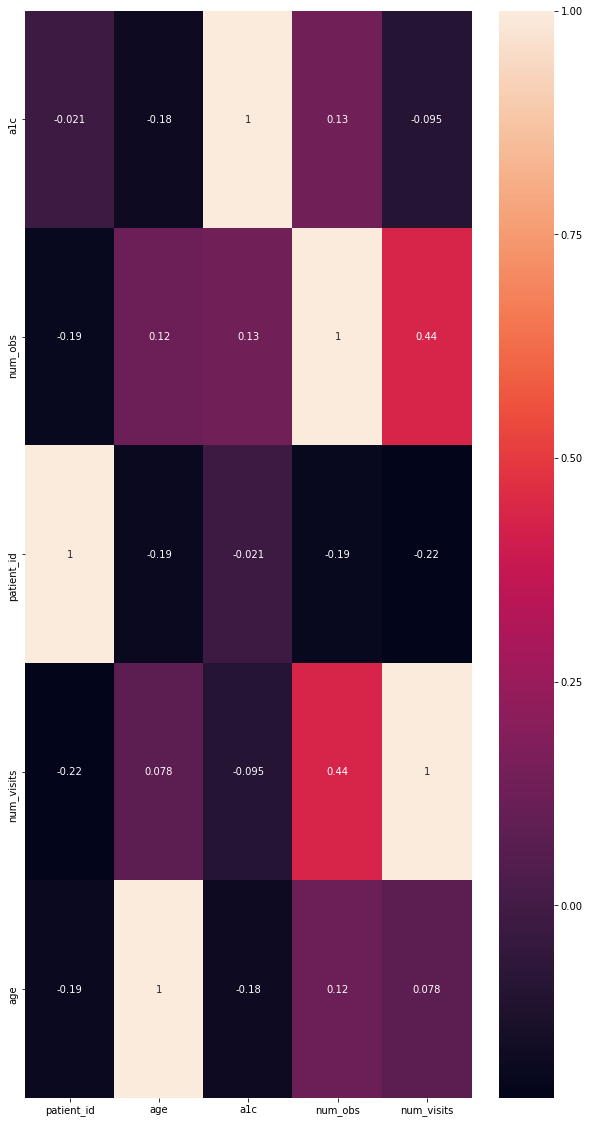

In [237]:
plt.figure(figsize=(10,20))
# sns.heatmap(new_data.corr()[["a1c"]].sort_values(by="a1c",ascending=False), annot=True)
sns.heatmap(new_data.corr().sort_values(by="a1c",ascending=False), annot=True)

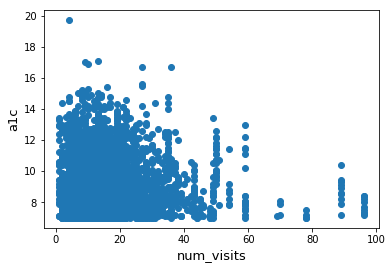

In [94]:
fig,ax=plt.subplots()
ax.scatter(x=new_data_aligned_no_dupes["num_visits"], y=new_data_aligned_no_dupes["a1c"])
plt.ylabel('a1c', fontsize=13)
plt.xlabel('num_visits', fontsize=13)
plt.show()

In [ ]:
ax = new_data(kind = 'bar')
ax.set_title('Controlled or uncontrolled vs num_visits', size = 0);
ax.set_ylabel('Average Price', size = 20);
ax.set_xlabel('House Style', size = 20);
ax.tick_params(labelsize = 'large')

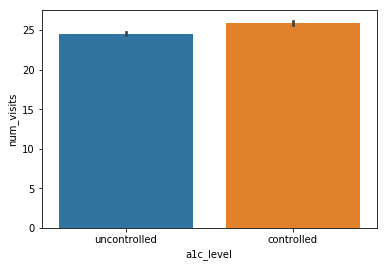

In [95]:
sns.barplot(x=new_data["a1c_level"],y=new_data['num_visits'])

In [98]:
new_data.groupby("num_visits")["a1c"].agg([np.mean,np.std]).sort_values(by="mean", ascending=False)

,mean,std
num_visits,,
50,10.785391,0.991796
35,10.525067,2.079987
1,9.955882,2.115340
24,9.706114,1.720569
4,9.633002,2.232612
27,9.615588,2.496270
19,9.499963,1.969831
34,9.439245,1.555423
38,9.375000,1.172083


In [112]:
new_data["num_visits"].median()

21.0

In [113]:
new_data["num_visits"].mean()

25.109019582519412

In [ ]:
new_data["num_visits"]

<Figure size 7200x14400 with 0 Axes>

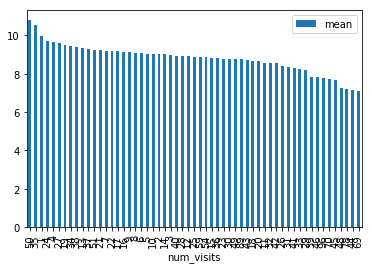

In [107]:
plt.figure(figsize=(100,200))
x = new_data.groupby("num_visits")["a1c"].agg([np.mean]).sort_values(by="mean", ascending=False).plot(kind = 'bar')
ax.set_title('Num visits by a1c', size = 0);
ax.set_ylabel('Average a1c', size = 20);
ax.set_xlabel('Avg visits', size = 20);
ax.tick_params(labelsize = 'large')

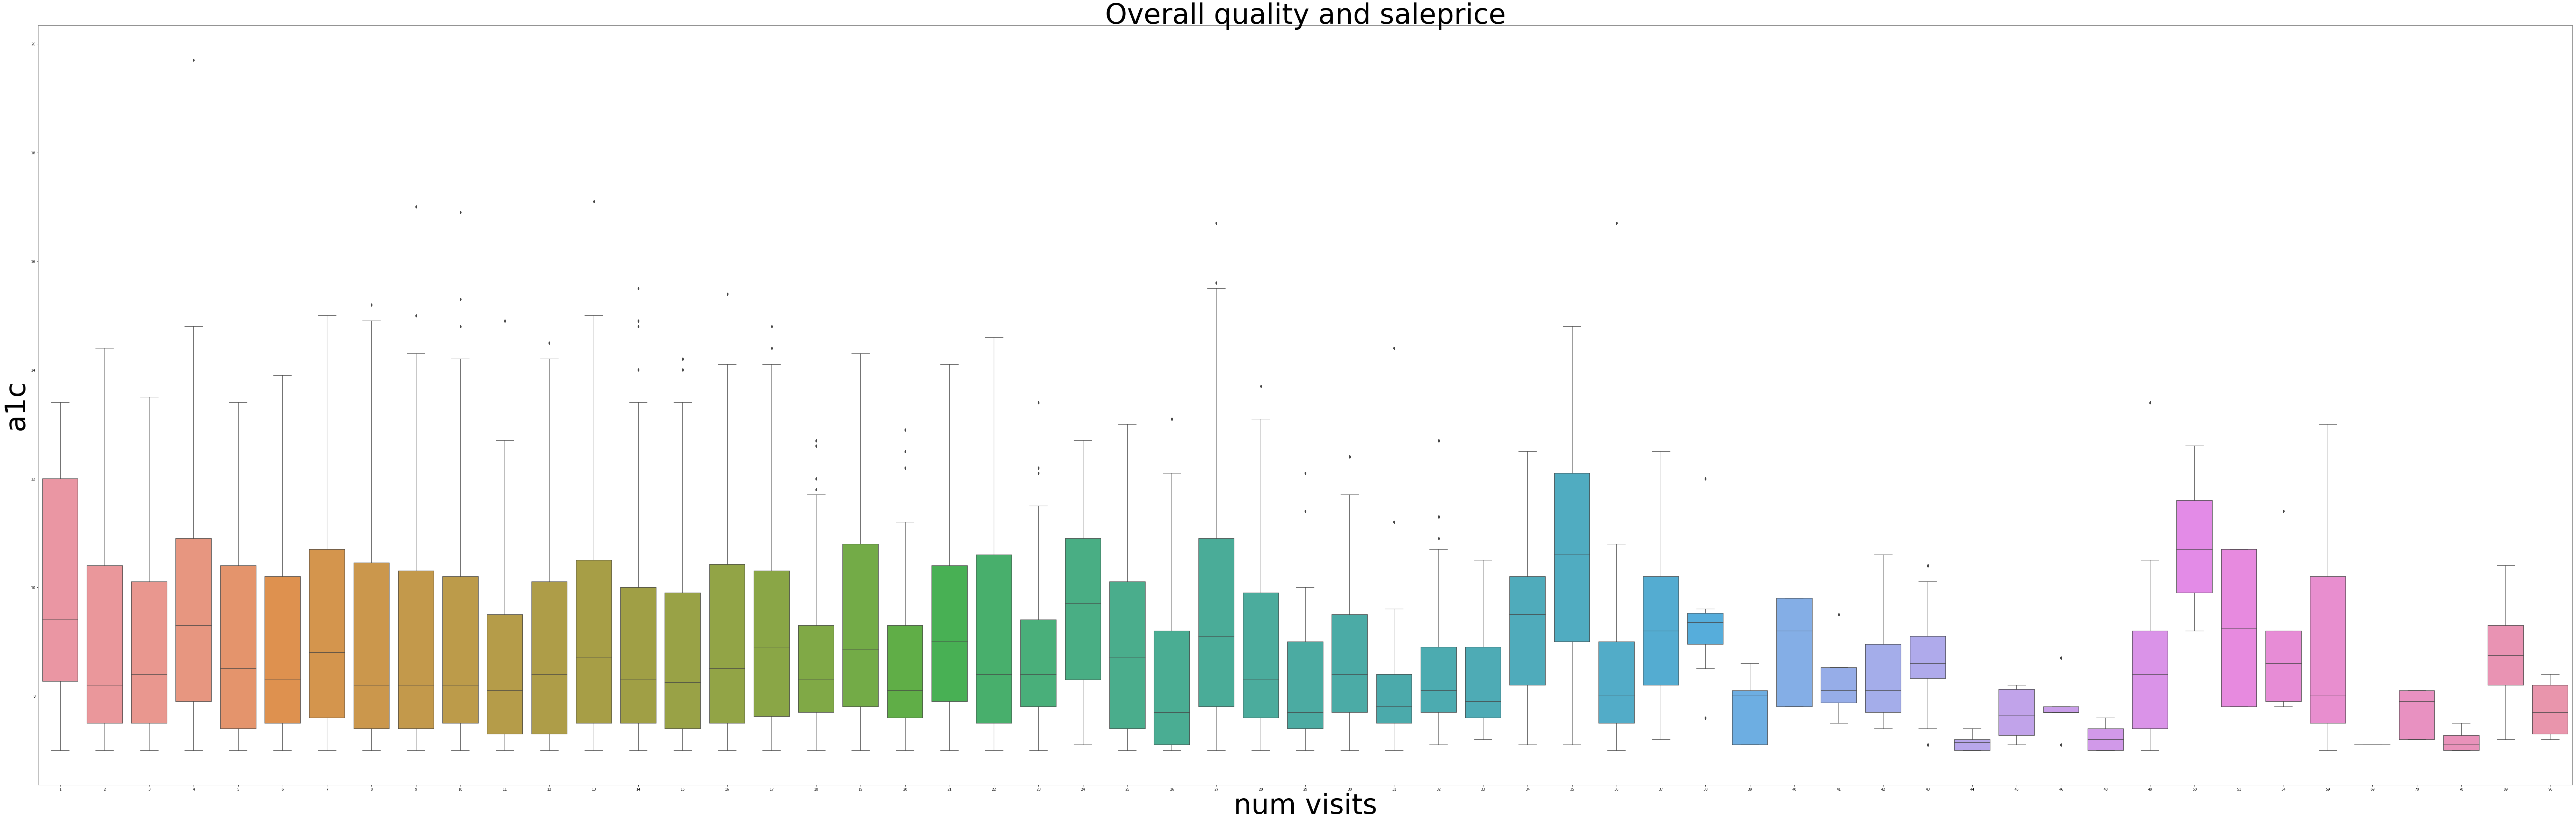

In [114]:
plt.figure(figsize=(130,40))
ax= sns.boxplot(new_data["num_visits"],new_data["a1c"])
# We see an increase in sale price related to overall quality

ax.set_title('Overall quality and saleprice', size = 80);
ax.set_ylabel('a1c', size = 80);
ax.set_xlabel('num visits', size = 80);

In [129]:
#TIME IN BETWEEN VISITS VS OVERALL AVERAGE A1C 
summary_and_visit_df["patient_id"].sort_values(by=)

,patient_id,age,visit_date,summary,num_visits
0,72,56,2017-07-19,"followup diabetes, med refill",10
6,72,56,2017-07-28,"f/u lab results, DM2, HLD",10
12,72,56,2017-11-08,DM and dyslipidemia follow-up,10
18,72,56,2018-02-16,Uncontrolled DM,10
24,72,56,2018-05-02,DM - hypoglycemia- dec. glyburide,10


In [173]:
sorted_sum= summary_and_visit_df.sort_values(by=["patient_id", "visit_date"])
#add column time in between visits 

In [174]:
sorted_sum.reset_index(inplace=True)

In [139]:
sorted_sum["visit_date"][2] - sorted_sum["visit_date"][1]

Timedelta('103 days 00:00:00')

In [175]:
sorted_sum.drop(columns=["index"],inplace=True)
#group by the patient_id and get the average time in between visits 


In [166]:
patient_sum=sorted_sum.loc[sorted_sum["patient_id"]==72]

In [167]:
patient_sum.head()

,patient_id,age,visit_date,summary,num_visits
0,72,56,2017-07-19,"followup diabetes, med refill",10
1,72,56,2017-07-28,"f/u lab results, DM2, HLD",10
2,72,56,2017-11-08,DM and dyslipidemia follow-up,10
3,72,56,2018-02-16,Uncontrolled DM,10
4,72,56,2018-05-02,DM - hypoglycemia- dec. glyburide,10


In [168]:
patient_sum["visit_date"][1] - patient_sum["visit_date"][0]

Timedelta('9 days 00:00:00')

In [220]:
sorted_sum['patient_id'].unique()

array([    72,    254,    255, ..., 243548, 243642, 243644])

In [ ]:

lambda val: val.to_numpy()/86400000000000

In [217]:
int(int(sorted_sum.loc[0, 'time_between_visits'].to_numpy())/86400000000000)

9

In [224]:
sorted_sum.loc[0, 'time_between_visits']

Timedelta('9 days 00:00:00')

In [226]:
sorted_sum['time_between_visits'].map(lambda val: type(val))

0        <class 'pandas._libs.tslibs.timedeltas.Timedel...
1        <class 'pandas._libs.tslibs.timedeltas.Timedel...
2        <class 'pandas._libs.tslibs.timedeltas.Timedel...
3        <class 'pandas._libs.tslibs.timedeltas.Timedel...
4        <class 'pandas._libs.tslibs.timedeltas.Timedel...
                               ...                        
14192    <class 'pandas._libs.tslibs.timedeltas.Timedel...
14193    <class 'pandas._libs.tslibs.timedeltas.Timedel...
14194    <class 'pandas._libs.tslibs.timedeltas.Timedel...
14195    <class 'pandas._libs.tslibs.timedeltas.Timedel...
14196                                        <class 'str'>
Name: time_between_visits, Length: 14197, dtype: object

In [228]:
sorted_sum['time_between_visits'].map(lambda val: pd.Timedleta(val).to_numpy())

AttributeError: module 'pandas' has no attribute 'Timedleta'

In [ ]:
def name_this_later(val):
    

In [223]:
sorted_sum['time_between_visits'].map(lambda val: int(int(val.to_numpy())/86400000000000))

AttributeError: 'str' object has no attribute 'to_numpy'

In [177]:
array_of_ids= np.unique(sorted_sum["patient_id"].values)

In [188]:
sorted_sum.head(50)

,patient_id,age,visit_date,summary,num_visits,time_between_visits
0,72,56,2017-07-19,"followup diabetes, med refill",10,9 days 00:00:00
1,72,56,2017-07-28,"f/u lab results, DM2, HLD",10,
2,72,56,2017-11-08,DM and dyslipidemia follow-up,10,
3,72,56,2018-02-16,Uncontrolled DM,10,
4,72,56,2018-05-02,DM - hypoglycemia- dec. glyburide,10,
5,72,56,2018-09-28,"Poorly controlled DM, osteoarthritis right thu...",10,
6,72,56,2019-01-18,Diabetes follow up,10,
7,72,56,2019-05-17,"f/u DM2, HLD",10,
8,72,56,2019-12-09,"DM (A1c 7.1%), needs PPSV23/PCV13 vaccines",10,
9,72,56,2020-01-03,"Worse a1c 8.2 from 7, no new meds, repeat lipids",10,


In [191]:
sorted_sum["time_between_visits"]=""

for i in range(sorted_sum.shape[0]):
    try:
        patient_sum= sorted_sum.loc[sorted_sum['patient_id'] == sorted_sum['patient_id'][i]]
        sorted_sum["time_between_visits"][i]= patient_sum["visit_date"][i+1] - patient_sum["visit_date"][i]
    except: 
        i= i+1

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [197]:
# sorted_sum.group_by("patient_id").agg
# sorted_sum.groupby("time_between_visits").mean()["patient_id"].sort_values(ascending=False)
sorted_sum.groupby("patient_id")["time_between_visits"].agg([np.mean]).sort_values(by="mean", ascending=False)

DataError: No numeric types to aggregate

In [203]:
pd.to_datetime(sorted_sum['time_between_visits'])

TypeError: <class 'pandas._libs.tslibs.timedeltas.Timedelta'> is not convertible to datetime

In [207]:
sorted_sum.loc[sorted_sum['patient_id'] == 72, 'time_between_visits'].mean()

TypeError: Could not convert NaT to numeric

In [186]:
sorted_sum[2]

KeyError: 2

In [204]:
sorted_sum.groupby('patient_id')['time_between_visits'].mean(numeric_only = False)

TypeError: Could not convert NaT to numeric

In [ ]:
new_data["num_obs"]=""

for i in range(new_data.shape[0]):
    try:
        mas=new_data.loc[new_data['patient_id'] == new_data['patient_id'][i]]
        new_data["num_obs"][i]= mas['obs_date'].nunique()
    except: 
        continue 

In [198]:
sorted_sum.head(60)

,patient_id,age,visit_date,summary,num_visits,time_between_visits
0,72,56,2017-07-19,"followup diabetes, med refill",10,9 days 00:00:00
1,72,56,2017-07-28,"f/u lab results, DM2, HLD",10,103 days 00:00:00
2,72,56,2017-11-08,DM and dyslipidemia follow-up,10,100 days 00:00:00
3,72,56,2018-02-16,Uncontrolled DM,10,75 days 00:00:00
4,72,56,2018-05-02,DM - hypoglycemia- dec. glyburide,10,149 days 00:00:00
5,72,56,2018-09-28,"Poorly controlled DM, osteoarthritis right thu...",10,112 days 00:00:00
6,72,56,2019-01-18,Diabetes follow up,10,119 days 00:00:00
7,72,56,2019-05-17,"f/u DM2, HLD",10,206 days 00:00:00
8,72,56,2019-12-09,"DM (A1c 7.1%), needs PPSV23/PCV13 vaccines",10,25 days 00:00:00
9,72,56,2020-01-03,"Worse a1c 8.2 from 7, no new meds, repeat lipids",10,
